<a href="https://colab.research.google.com/github/Indhusaikar/My-QC/blob/main/COVID_19_Lung_CT_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install pennylane
from IPython.display import clear_output
clear_output()

In [ ]:
# Standard Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/COVID-19_Lung_CT_Scans"
COVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19_Lung_CT_Scans/COVID-19")
NONCOVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19_Lung_CT_Scans/Non-COVID-19")


In [ ]:
def load_images_from_folder(folder_path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load COVID and Non-COVID images
covid_images, covid_labels = load_images_from_folder(COVID_PATH, 1)
noncovid_images, noncovid_labels = load_images_from_folder(NONCOVID_PATH, 0)

# Combine and convert to numpy arrays
X = np.array(covid_images + noncovid_images)
y = np.array(covid_labels + noncovid_labels)

# Expand dimensions for CNN
X = X.reshape(-1, 128, 128, 1) / 255.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
x

In [ ]:
# Set up the device with 8 qubits
dev = qml.device("default.qubit", wires=10)

H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)

    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # First Convolution

    qml.CRY(phi=phis[0], wires=[7, 6])

    qml.CRY(phi=phis[1], wires=[6, 5])

    qml.CRY(phi=phis[2], wires=[5, 4])

    qml.CRY(phi=phis[3], wires=[4, 7])

    qml.CRY(phi=phis[4], wires=[3, 2])

    qml.CRY(phi=phis[5], wires=[2, 1])

    qml.CRY(phi=phis[6], wires=[1, 0])

    qml.CRY(phi=phis[7], wires=[0, 3])

    qml.Barrier()


    # First Pooling

    qml.CRZ(phi=phis[8], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[9], wires=[7, 6])

    qml.CRZ(phi=phis[8], wires=[3, 2])
    qml.X(wires=3)
    qml.CRX(phi=phis[9], wires=[3, 2])

    qml.Barrier()

    # Activations 1
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[10], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[11], wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(phi=phis[12], wires=2)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[13], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[14], wires=5)
    qml.Hadamard(wires=6)
    qml.RZ(phi=phis[15], wires=6)

    qml.Barrier()

    # Second Convolution

    qml.CRY(phi=phis[16], wires=[6, 5])

    qml.CRY(phi=phis[17], wires=[5, 4])

    qml.CRY(phi=phis[18], wires=[4, 6])

    qml.CRY(phi=phis[19], wires=[2, 1])

    qml.CRY(phi=phis[20], wires=[1, 0])

    qml.CRY(phi=phis[21], wires=[0, 2])

    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[22], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[23], wires=[6, 5])

    qml.CRZ(phi=phis[22], wires=[2, 1])
    qml.X(wires=2)
    qml.CRX(phi=phis[23], wires=[2, 1])

    qml.Barrier()

    # Activations 2
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[24], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[25], wires=1)

    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[26], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[27], wires=5)

    qml.Barrier()

    # Third Convolution

    qml.CRY(phi=phis[28], wires=[5, 4])

    qml.CRY(phi=phis[29], wires=[4, 5])

    qml.CRY(phi=phis[30], wires=[1, 0])

    qml.CRY(phi=phis[31], wires=[0, 1])

    qml.Barrier()

    # Third Pooling

    qml.CRZ(phi=phis[32], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[33], wires=[5, 4])

    qml.CRZ(phi=phis[32], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[33], wires=[1, 0])

    # Ancilla qubits
    qml.CNOT(wires=[0, 8])
    qml.CNOT(wires=[4, 9])

    # Return the final state vector
    return qml.probs(wires=[8, 9])

results = []

for i in range(100):
    # Execute the circuit and retrieve the state vector
    phis = np.random.uniform(-1, 1, size=34)
    state_vector = quantum_circuit(X_train[i], phis)

    # Convert the state vector into probabilities by taking the absolute square of each amplitude
    probabilities = np.abs(state_vector)**2

    results.append(probabilities)

    # Print the resulting probabilities
    #print("Probabilities:", probabilities.numpy())

    # Reshape the probabilities array into a 16x16 array for the heatmap
    '''probabilities_reshaped = probabilities.reshape(2, 2)'''

    # Create a heatmap of the probabilities using seaborn
    '''plt.figure(figsize=(8, 6))
    sns.heatmap(probabilities_reshaped, annot=False, cmap="viridis")

    # Add labels and title
    plt.title("Heatmap of Probabilities for 8-Qubit Quantum Circuit")
    plt.xlabel("State Index (0-15)")
    plt.ylabel("State Index (0-15)")'''

    # Show the plot
    #plt.show()

highest = {0: 0, 1: 0, 2: 0, 3: 0}

for i in results:
    ind = 0
    m = i[0]

    if i[1] > m:
        ind = 1
        m = i[1]
    if i[2] > m:
        ind = 2
        m = i[2]
    if i[3] > m:
        ind = 3
        m = i[3]

    highest[ind] += 1

highest

ValueError: State must be a one-dimensional tensor, or two-dimensional with batching; got shape (128, 128, 1).

In [ ]:
# Resize images to 16x16 for Amplitude Embedding (256 features for 8 qubits)
# Assuming X_train and X_test are already loaded and preprocessed as numpy arrays
X_train_resized = X_train.reshape(-1, 128, 128) # Remove the channel dimension for resizing
X_test_resized = X_test.reshape(-1, 128, 128)

# Use cv2.resize for resizing
X_train_resized = np.array([cv2.resize(img, (16, 16)) for img in X_train_resized])
X_test_resized = np.array([cv2.resize(img, (16, 16)) for img in X_test_resized])

# Flatten the resized images to a 1D vector of size 256
X_train_flat = X_train_resized.reshape(-1, 16*16)
X_test_flat = X_test_resized.reshape(-1, 16*16)

print(f"Resized and flattened training data shape: {X_train_flat.shape}")
print(f"Resized and flattened testing data shape: {X_test_flat.shape}")

Resized and flattened training data shape: (1044, 256)
Resized and flattened testing data shape: (262, 256)


In [ ]:
import pennylane as qml
import numpy as np

# Set up the device with 10 qubits (8 for features, 2 for ancilla)
dev = qml.device("default.qubit", wires=10)

# Define the quantum circuit
@qml.qnode(dev, interface='autograd') # Using autograd interface for numpy arrays
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 256 states (2^8 = 256)
    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # First Convolution
    qml.CRY(phi=phis[0], wires=[7, 6])
    qml.CRY(phi=phis[1], wires=[6, 5])
    qml.CRY(phi=phis[2], wires=[5, 4])
    qml.CRY(phi=phis[3], wires=[4, 7])
    qml.CRY(phi=phis[4], wires=[3, 2])
    qml.CRY(phi=phis[5], wires=[2, 1])
    qml.CRY(phi=phis[6], wires=[1, 0])
    qml.CRY(phi=phis[7], wires=[0, 3])
    qml.Barrier()

    # First Pooling
    qml.CRZ(phi=phis[8], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[9], wires=[7, 6])
    qml.CRZ(phi=phis[8], wires=[3, 2])
    qml.X(wires=3)
    qml.CRX(phi=phis[9], wires=[3, 2])
    qml.Barrier()

    # Activations 1
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[10], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[11], wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(phi=phis[12], wires=2)
    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[13], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[14], wires=5)
    qml.Hadamard(wires=6)
    qml.RZ(phi=phis[15], wires=6)
    qml.Barrier()

    # Second Convolution
    qml.CRY(phi=phis[16], wires=[6, 5])
    qml.CRY(phi=phis[17], wires=[5, 4])
    qml.CRY(phi=phis[18], wires=[4, 6])
    qml.CRY(phi=phis[19], wires=[2, 1])
    qml.CRY(phi=phis[20], wires=[1, 0])
    qml.CRY(phi=phis[21], wires=[0, 2])
    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[22], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[23], wires=[6, 5])
    qml.CRZ(phi=phis[22], wires=[2, 1])
    qml.X(wires=2)
    qml.CRX(phi=phis[23], wires=[2, 1])
    qml.Barrier()

    # Activations 2
    qml.Hadamard(wires=0)
    qml.RZ(phi=phis[24], wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(phi=phis[25], wires=1)
    qml.Hadamard(wires=4)
    qml.RZ(phi=phis[26], wires=4)
    qml.Hadamard(wires=5)
    qml.RZ(phi=phis[27], wires=5)
    qml.Barrier()

    # Third Convolution
    qml.CRY(phi=phis[28], wires=[5, 4])
    qml.CRY(phi=phis[29], wires=[4, 5])
    qml.CRY(phi=phis[30], wires=[1, 0])
    qml.CRY(phi=phis[31], wires=[0, 1])
    qml.Barrier()

    # Third Pooling
    qml.CRZ(phi=phis[32], wires=[5, 4])
    qml.X(wires=5)
    qml.CRX(phi=phis[33], wires=[5, 4])
    qml.CRZ(phi=phis[32], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[33], wires=[1, 0])

    # Ancilla qubits
    qml.CNOT(wires=[0, 8])
    qml.CNOT(wires=[4, 9])

    # Return the probabilities of the ancilla qubits
    return qml.probs(wires=[8, 9])

results = []

for i in range(100):
    # Execute the circuit and retrieve the state vector
    phis = np.random.uniform(-1, 1, size=34)
    # Use the resized and flattened training data
    probabilities = quantum_circuit(X_train_flat[i], phis)

    results.append(probabilities)

    # Print the resulting probabilities
    #print("Probabilities:", probabilities.numpy())

    # Reshape the probabilities array into a 2x2 array for the heatmap (ancilla qubits can be in states 00, 01, 10, 11)
    # probabilities_reshaped = probabilities.reshape(2, 2)

    # Create a heatmap of the probabilities using seaborn
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(probabilities_reshaped, annot=False, cmap="viridis")

    # Add labels and title
    # plt.title("Heatmap of Probabilities for Ancilla Qubits")
    # plt.xlabel("Ancilla Qubit 9 State")
    # plt.ylabel("Ancilla Qubit 8 State")

    # Show the plot
    # plt.show()

highest = {0: 0, 1: 0, 2: 0, 3: 0}

for i in results:
    ind = 0
    m = i[0]

    if i[1] > m:
        ind = 1
        m = i[1]
    if i[2] > m:
        ind = 2
        m = i[2]
    if i[3] > m:
        ind = 3
        m = i[3]

    highest[ind] += 1

highest

{0: 18, 1: 18, 2: 26, 3: 38}

In [ ]:
for i in results:
    print(i**(1/2))

[0.35259151 0.38962407 0.54350522 0.65457955]
[0.56366871 0.42498099 0.5622319  0.43077144]
[0.37458039 0.420748   0.54218809 0.62345227]
[0.50685601 0.52826736 0.46637539 0.49651241]
[0.42796447 0.23746113 0.77958964 0.39076671]
[0.44996867 0.65269815 0.34261147 0.50411378]
[0.50765927 0.53059551 0.43640727 0.51990304]
[0.42246031 0.54845051 0.44721389 0.56632946]
[0.29023199 0.24730765 0.77770467 0.49977971]
[0.35439771 0.4317531  0.54175182 0.62808955]
[0.49962023 0.45190172 0.54769508 0.49617998]
[0.49163072 0.54908828 0.45149091 0.50294856]
[0.44694258 0.51458731 0.48342536 0.54931062]
[0.48198697 0.45136559 0.57552748 0.4824166 ]
[0.3816996  0.60223671 0.38637849 0.58508805]
[0.49476945 0.3332855  0.66685127 0.44657962]
[0.42807049 0.44587356 0.51380578 0.59494205]
[0.40529165 0.3983104  0.63693065 0.52096723]
[0.28773767 0.34336231 0.5597991  0.6970899 ]
[0.31789111 0.51481468 0.38997606 0.69413958]
[0.40754675 0.49195608 0.47410241 0.60589749]
[0.31704125 0.30746739 0.63134022 

(<Figure size 3500x1100 with 1 Axes>, <Axes: >)


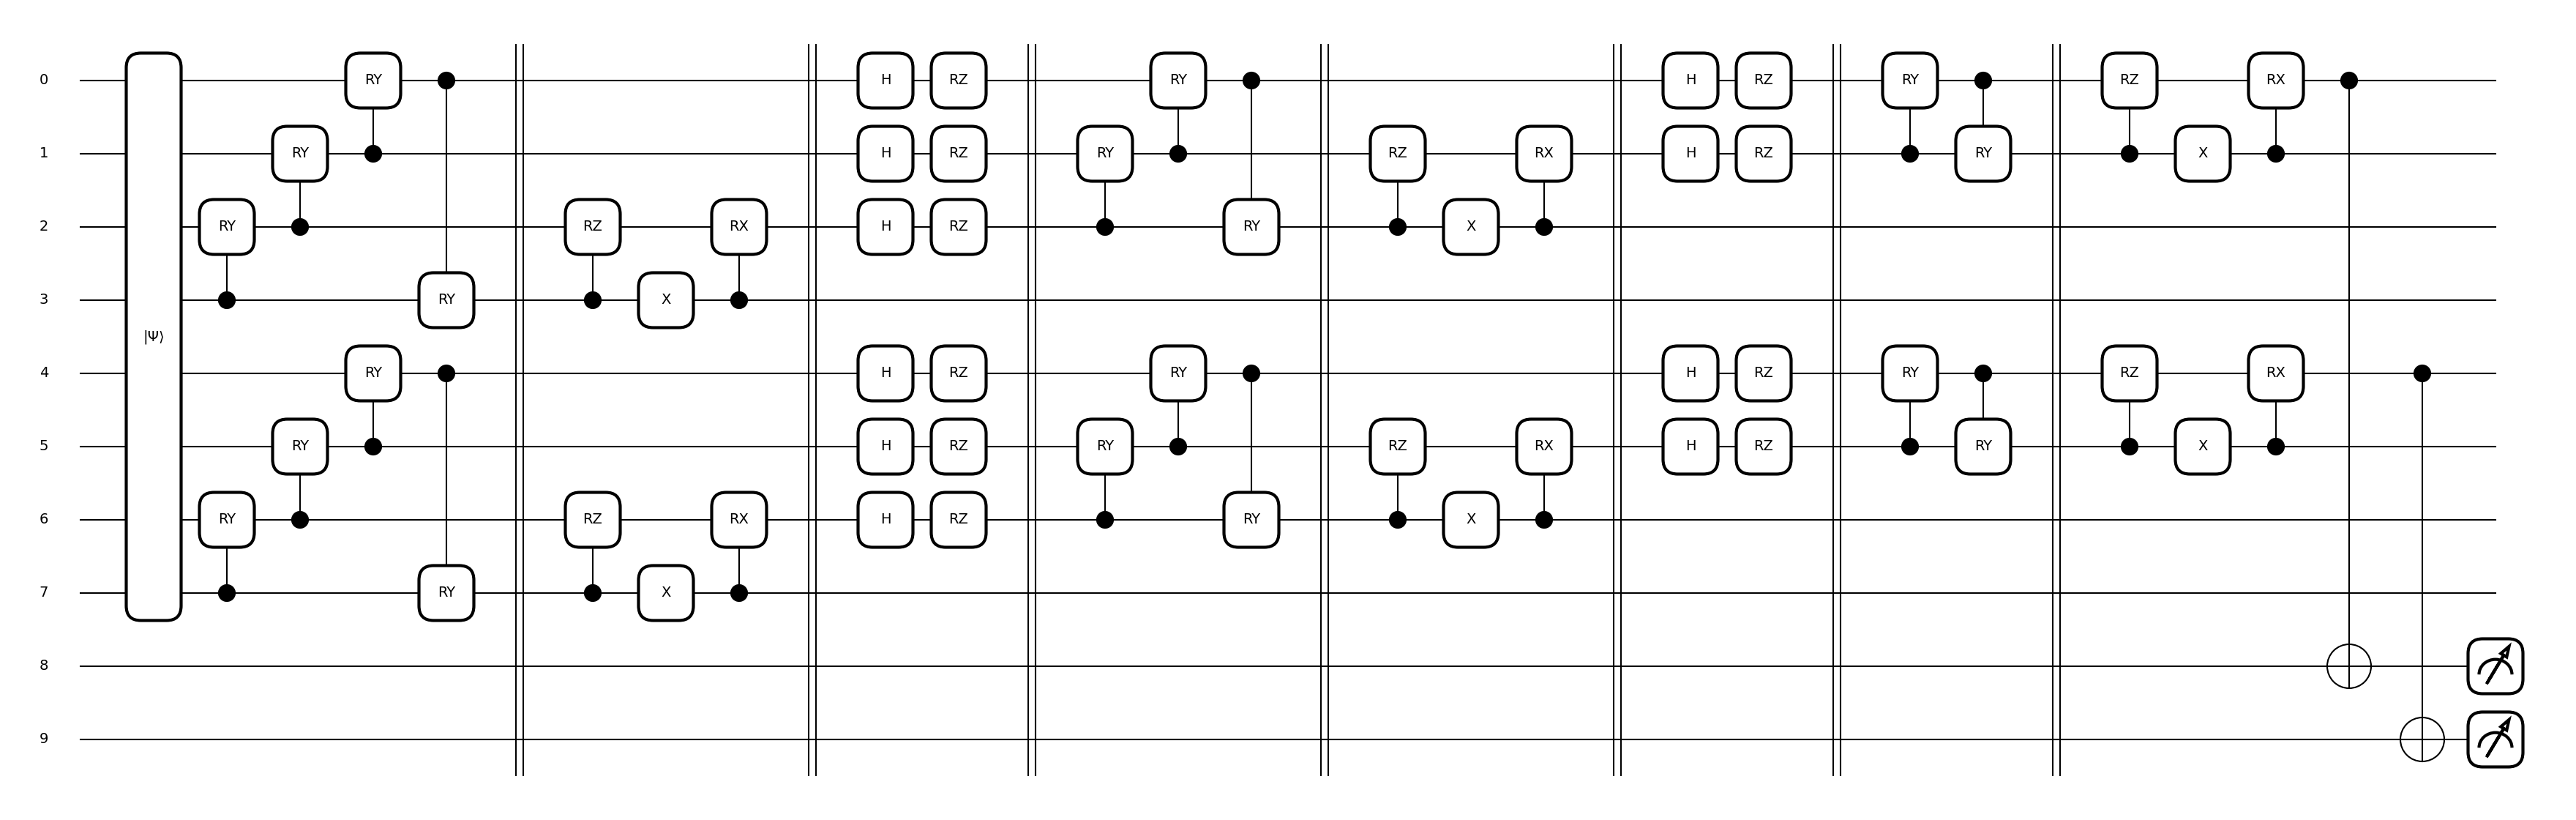

In [ ]:
drawer = qml.draw_mpl(quantum_circuit)(X_train_flat[0], phis)
print(drawer)

In [ ]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        self.phis = torch.nn.Parameter(torch.empty(34))  # Create an uninitialized tensor of size 17
        torch.nn.init.uniform_(self.phis, a=-0.314, b=0.314)  # Initialize phis with values between -0.01 and 0.01

    def forward(self, x):
        # Call the quantum circuit and return the log-probabilities
        constrained_phis = self.phis * np.pi  # Optional: Mapping the parameters to [-pi, pi] without tanh
        return torch.log(quantum_circuit(x, constrained_phis))

In [ ]:
# Set up the model, optimizer, and loss function
model = QCNN()
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()  # Use NLLLoss since output is probabilities

In [ ]:
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

In [ ]:
import torch
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# Convert prepared data to PyTorch tensors
# Use the flattened training and testing data (X_train_flat, X_test_flat)
# and the original labels (y_train, y_test)

# Split the training data into training and validation sets
# Using 80% for training and 20% for validation from the original training set
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_flat, y_train, test_size=0.2, random_state=42
)

X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Convert the split data to tensors
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_tensor, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.long)


phi_history = []
loss_history = []
val_loss_history = []
accuracy_history = [0.0]
val_accuracy_history = [0.0]


# Early Stopping params
patience = 10
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Training loop
num_epochs = 100  # Adjust as needed
batch_size = 32

for epoch in range(num_epochs):

    if early_stop:
        print("Early stopping triggered.")
        break

    epoch_loss = 0
    model.train()

    # Keep a record of parameter (phi) values
    phi_history.append(model.phis.clone().detach().numpy())

    # Shuffle the training data at the start of each epoch
    torch.manual_seed(seed + epoch)
    permutation = torch.randperm(X_train_tensor.size()[0])
    X_train_tensor = X_train_tensor[permutation]
    y_train_tensor = y_train_tensor[permutation]

    # Iterate over batches
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()

        # Forward pass: compute predictions
        outputs = model(x_batch)

        # Compute cross-entropy loss
        loss = loss_fn(outputs, y_batch)

        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Compute accuracy on the training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_accuracy = compute_accuracy(train_outputs, y_train_tensor)
        accuracy_history.append(train_accuracy)
        loss_history.append(loss.item()) # Store the scalar loss value

    #print(f"Training Accuracy: {train_accuracy:.4f}")

    # Validation loss (on validation data)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = loss_fn(val_outputs, y_val_tensor).item()
        val_accuracy = compute_accuracy(val_outputs, y_val_tensor)
        val_accuracy_history.append(val_accuracy)
        val_loss_history.append(val_loss)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / (len(X_train_tensor) / batch_size):.4f}, Accuracy: {train_accuracy:.4f}  -  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    if epochs_no_improve > 0:
        print(f"Epochs without improvement: {epochs_no_improve}")
    else:
        print("\n")

print("Training finished.")

/usr/local/lib/python3.11/dist-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch 1/100, Loss: 0.5678, Accuracy: 0.7856  -  Validation Loss: 0.5951, Validation Accuracy: 0.7321


Epoch 2/100, Loss: 0.5294, Accuracy: 0.7868  -  Validation Loss: 0.5930, Validation Accuracy: 0.7321


Epoch 3/100, Loss: 0.5613, Accuracy: 0.7868  -  Validation Loss: 0.5940, Validation Accuracy: 0.7321
Epochs without improvement: 1
Epoch 4/100, Loss: 0.5282, Accuracy: 0.7868  -  Validation Loss: 0.5929, Validation Accuracy: 0.7321


Epoch 5/100, Loss: 0.5295, Accuracy: 0.7868  -  Validation Loss: 0.5943, Validation Accuracy: 0.7321
Epochs without improvement: 1
Epoch 6/100, Loss: 0.5325, Accuracy: 0.7856  -  Validation Loss: 0.5958, Validation Accuracy: 0.7321
Epochs without improvement: 2
Epoch 7/100, Loss: 0.5323, Accuracy: 0.7868  -  Validation Loss: 0.5951, Validation Accuracy: 0.7321
Epochs without improvement: 3
Epoch 8/100, Loss: 0.5483, Accuracy: 0.7856  -  Validation Loss: 0.5954, Validation Accuracy: 0.7321
Epochs without improvement: 4
Epoch 9/100, Loss: 0.5310, Accuracy:

In [ ]:
from collections import defaultdict

# Initialize a dictionary to store counts per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

test_outs = None
model.eval()

# List of class labels
class_labels = [0, 1]

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outs = test_outputs
    _, predicted = torch.max(test_outputs, 1)

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Calculate accuracy per class
    for i in range(len(y_test_tensor)):
        label = y_test_tensor[i].item()
        pred = predicted[i].item()

        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

# Print accuracy for each class
for label in class_labels:
    if class_total[label] > 0:
        class_accuracy = class_correct[label] / class_total[label]
        print(f"Accuracy for class {label}: {class_accuracy:.4f}")
    else:
        print(f"No samples found for class {label}.")

Overall Test Accuracy: 0.7481
Accuracy for class 0: 0.0000
Accuracy for class 1: 0.9949


/usr/local/lib/python3.11/dist-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [ ]:
# Evaluation on the test set
test_outs = None
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_outs = test_outputs
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7481


/usr/local/lib/python3.11/dist-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


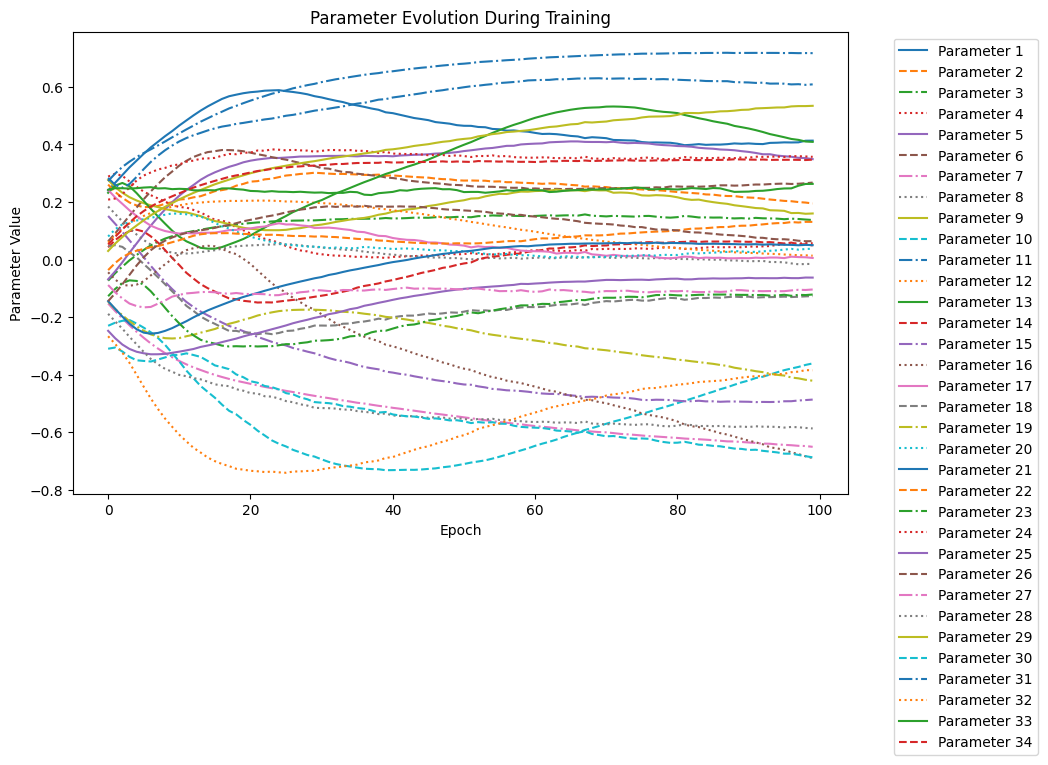

In [ ]:
# Plot parameter history
parameter_history = np.array(phi_history)  # Convert to NumPy array for easier manipulation

# Defined line styes
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(10, 6))
for i in range(len(model.phis)):  # 17 parameters
    plt.plot(parameter_history[:, i], label=f'Parameter {i+1}', linestyle=line_styles[i % len(line_styles)])

plt.title("Parameter Evolution During Training")
plt.xlabel("Epoch")
plt.ylabel("Parameter Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
plt.show()

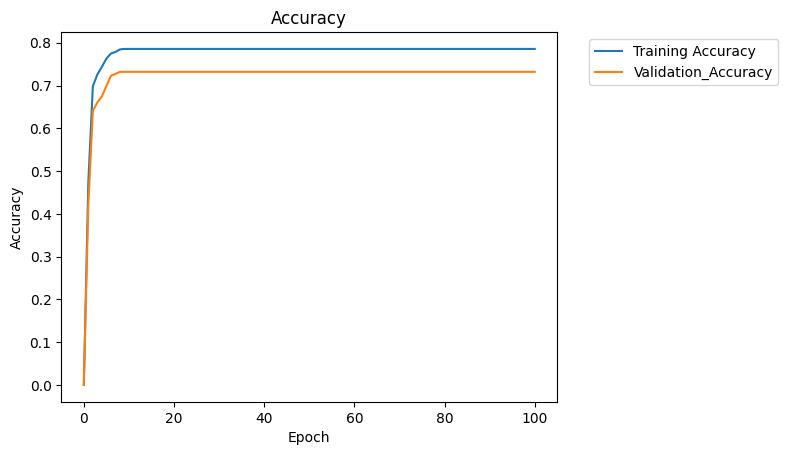

In [43]:
plt.plot(accuracy_history, label="Training Accuracy")
plt.plot(val_accuracy_history, label="Validation_Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()